In [39]:
%load_ext autoreload
%autoreload 2

#Import general libraries (needed for functions)
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

#Import the RB Functions
import qiskit.ignis.verification.randomized_benchmarking as rb


#Import Qiskit classes 
import qiskit
from qiskit.providers.aer import noise
import qiskit.quantum_info as qi
from qiskit.providers.aer.noise.errors.standard_errors import depolarizing_error, thermal_relaxation_error

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# leakage RB

## Step1. Define leakage error model

In [45]:
def leakage_error(qubit_error, p_leakage):
    no_leak = qi.Choi(qubit_error).expand(qi.Operator([[1,0], [0, 1]]))
    leak = qi.Choi(qubit_error).expand(qi.Operator([[0,1],[1,0]]))
    
    return (1 - p_leakage) * no_leak + p_leakage * leak

p_depol1 = 0.01
p_depol2 = 0.01
p_leakage1 = 0.01
p_leakage2 = 0.01
error_1q_leakage = leakage_error(noise.errors.depolarizing_error(p_depol1, 1), p_leakage1)
error_2q_leakage = leakage_error(noise.errors.depolarizing_error(p_depol2, 2), p_leakage2)

noise_leakage = noise.NoiseModel()
noise_leakage.add_nonlocal_quantum_error(error_1q_leakage, ['u1', 'u2', 'u3'], [0], [0, 2])
noise_leakage.add_nonlocal_quantum_error(error_1q_leakage, ['u1', 'u2', 'u3'], [1], [1, 2])
noise_leakage.add_nonlocal_quantum_error(error_2q_leakage, ['cx'], [0, 1], [0, 1, 2])
noise_leakage.add_nonlocal_quantum_error(error_2q_leakage, ['cx'], [1, 0], [1, 0, 2])
print(nm)

NoiseModel:
  Basis gates: ['cx', 'id', 'u1', 'u2', 'u3']
  Instructions with noise: ['u3', 'u2', 'cx', 'u1']
  Qubits with noise: [0, 1, 2]
  Non-local specific qubit errors: [('u1', [0], [0, 2]), ('u1', [1], [1, 2]), ('u2', [0], [0, 2]), ('u2', [1], [1, 2]), ('u3', [0], [0, 2]), ('u3', [1], [1, 2]), ('cx', [0, 1], [0, 1, 2]), ('cx', [1, 0], [1, 0, 2])]


## Step2. Define the RB circuit

In [46]:
#Generate RB circuits (2Q RB)

#number of qubits
nQ=2 


rb_opts = {}


#Number of Cliffords in the sequence
length_vector = [1, 10, 20, 50, 75, 100, 125, 150, 175, 200]
rb_opts['length_vector'] = length_vector

#Number of seeds (random sequences)
nseeds = 5
rb_opts['nseeds'] = nseeds

## Default pattern

rb_pattern = [[0,1]]
rb_opts['rb_pattern'] = rb_pattern ## ここは一つだと動かないので、あとで治す


is_leakage = True
rb_opts['is_leakage'] = is_leakage


print(rb_opts)
"""
rb_circs: circuits for randomized benchmarking

xdata: the length of clifford group
"""
rb_circs, xdata= rb.randomized_benchmarking_seq(**rb_opts)


{'length_vector': [1, 10, 20, 50, 75, 100, 125, 150, 175, 200], 'nseeds': 5, 'rb_pattern': [[0, 1]], 'is_leakage': True}


In [47]:
rb_circs[0][0][0].draw()

In [48]:
rb_circs[0][0][1].draw()

In [98]:
# Create the RB fitter
backend = qiskit.Aer.get_backend('qasm_simulator')
basis_gates = ['u1','u2','u3','cx'] 
shots = 100
qobj_list = []

if is_leakage:

    counts_list = []
    for rb_seed,rb_circ_seed in enumerate(rb_circs):

        print('################### Compiling seed %d ###################'%rb_seed)

        count_seed = []
        for meas_x in range(2**nQ):
            print("meas_x: %d"%meas_x)
            _rb_circ_seed_xmeas = []
            _len_v = len(length_vector)

            #  クリフォードの長さごとの
            count_measx = []
            for i in range(_len_v):
                _rb_circ_seed_xmeas.append(rb_circ_seed[i][meas_x])

                new_rb_circ_seed = qiskit.compiler.transpile(_rb_circ_seed_xmeas, basis_gates=basis_gates)
                qobj = qiskit.compiler.assemble(new_rb_circ_seed, shots=shots)
                print('Simulating seed %d'%rb_seed)

                ## run on simulator 
                job = backend.run(qobj, noise_model=noise_leakage, backend_options={'max_parallel_experiments': 0})
                qobj_list.append(qobj)

                counts = job.result().get_counts(i)
                count_measx.append(counts)
                print("count_measx = ", count_measx)
                
            count_seed.append(count_measx)
            print("count_seed = ", count_seed)
        counts_list.append(count_seed)

################### Compiling seed 0 ###################
meas_x: 0
Simulating seed 0
count_measx =  [{'1 00': 1, '0 00': 24, '0 10': 25, '0 11': 26, '0 01': 24}]
Simulating seed 0
count_measx =  [{'1 00': 1, '0 00': 24, '0 10': 25, '0 11': 26, '0 01': 24}, {'1 01': 11, '0 00': 30, '0 10': 9, '0 11': 4, '1 11': 3, '1 00': 10, '1 10': 3, '0 01': 30}]
Simulating seed 0
count_measx =  [{'1 00': 1, '0 00': 24, '0 10': 25, '0 11': 26, '0 01': 24}, {'1 01': 11, '0 00': 30, '0 10': 9, '0 11': 4, '1 11': 3, '1 00': 10, '1 10': 3, '0 01': 30}, {'1 01': 15, '0 00': 13, '0 10': 13, '0 11': 19, '1 11': 13, '1 00': 13, '1 10': 6, '0 01': 8}]
Simulating seed 0
count_measx =  [{'1 00': 1, '0 00': 24, '0 10': 25, '0 11': 26, '0 01': 24}, {'1 01': 11, '0 00': 30, '0 10': 9, '0 11': 4, '1 11': 3, '1 00': 10, '1 10': 3, '0 01': 30}, {'1 01': 15, '0 00': 13, '0 10': 13, '0 11': 19, '1 11': 13, '1 00': 13, '1 10': 6, '0 01': 8}, {'1 01': 14, '0 00': 7, '0 10': 17, '0 11': 17, '1 11': 16, '1 00': 10, '1 10':

Simulating seed 0
count_measx =  [{'1 00': 2, '0 11': 28, '0 00': 24, '0 01': 24, '0 10': 19, '1 10': 2, '1 11': 1}, {'1 01': 2, '0 00': 6, '0 10': 29, '0 11': 26, '1 11': 16, '1 00': 1, '1 10': 14, '0 01': 6}, {'1 01': 14, '0 00': 19, '0 10': 13, '0 11': 15, '1 11': 11, '1 00': 10, '1 10': 9, '0 01': 9}, {'1 01': 13, '0 00': 13, '0 10': 8, '0 11': 9, '1 11': 14, '1 00': 11, '1 10': 17, '0 01': 15}, {'1 01': 18, '0 00': 12, '0 10': 10, '0 11': 10, '1 11': 10, '1 00': 15, '1 10': 14, '0 01': 11}, {'1 01': 9, '0 00': 15, '0 10': 11, '0 11': 18, '1 11': 10, '1 00': 12, '1 10': 12, '0 01': 13}, {'1 01': 11, '0 00': 13, '0 10': 10, '0 11': 10, '1 11': 17, '1 00': 11, '1 10': 10, '0 01': 18}]
Simulating seed 0
count_measx =  [{'1 00': 2, '0 11': 28, '0 00': 24, '0 01': 24, '0 10': 19, '1 10': 2, '1 11': 1}, {'1 01': 2, '0 00': 6, '0 10': 29, '0 11': 26, '1 11': 16, '1 00': 1, '1 10': 14, '0 01': 6}, {'1 01': 14, '0 00': 19, '0 10': 13, '0 11': 15, '1 11': 11, '1 00': 10, '1 10': 9, '0 01': 9

Simulating seed 0
count_measx =  [{'1 00': 2, '0 11': 21, '0 00': 25, '0 01': 22, '0 10': 28, '1 10': 1, '1 11': 1}, {'1 00': 14, '0 11': 11, '1 01': 12, '0 00': 28, '0 10': 6, '1 10': 3, '0 01': 26}, {'1 01': 11, '0 00': 10, '0 10': 14, '0 11': 12, '1 11': 13, '1 00': 14, '1 10': 11, '0 01': 15}, {'1 01': 19, '0 00': 10, '0 10': 12, '0 11': 9, '1 11': 15, '1 00': 17, '1 10': 7, '0 01': 11}, {'1 01': 13, '0 00': 8, '0 10': 17, '0 11': 11, '1 11': 8, '1 00': 13, '1 10': 19, '0 01': 11}, {'1 01': 14, '0 00': 12, '0 10': 13, '0 11': 15, '1 11': 14, '1 00': 13, '1 10': 8, '0 01': 11}, {'1 01': 11, '0 00': 9, '0 10': 16, '0 11': 11, '1 11': 12, '1 00': 11, '1 10': 14, '0 01': 16}, {'1 01': 14, '0 00': 10, '0 10': 8, '0 11': 20, '1 11': 10, '1 00': 14, '1 10': 9, '0 01': 15}, {'1 01': 11, '0 00': 14, '0 10': 13, '0 11': 13, '1 11': 9, '1 00': 13, '1 10': 14, '0 01': 13}]
Simulating seed 0
count_measx =  [{'1 00': 2, '0 11': 21, '0 00': 25, '0 01': 22, '0 10': 28, '1 10': 1, '1 11': 1}, {'1 0

Simulating seed 0
count_measx =  [{'1 00': 3, '1 01': 2, '0 00': 21, '0 01': 20, '0 10': 23, '0 11': 29, '1 11': 2}, {'1 01': 2, '0 00': 5, '0 10': 29, '0 11': 31, '1 11': 15, '1 00': 1, '1 10': 13, '0 01': 4}, {'1 01': 9, '0 00': 10, '0 10': 14, '0 11': 7, '1 11': 15, '1 00': 16, '1 10': 14, '0 01': 15}, {'1 01': 11, '0 00': 12, '0 10': 14, '0 11': 13, '1 11': 8, '1 00': 12, '1 10': 14, '0 01': 16}, {'1 01': 6, '0 00': 14, '0 10': 12, '0 11': 12, '1 11': 7, '1 00': 19, '1 10': 10, '0 01': 20}, {'1 01': 12, '0 00': 12, '0 10': 15, '0 11': 13, '1 11': 8, '1 00': 11, '1 10': 14, '0 01': 15}, {'1 01': 15, '0 00': 11, '0 10': 11, '0 11': 11, '1 11': 13, '1 00': 15, '1 10': 10, '0 01': 14}, {'1 01': 15, '0 00': 11, '0 10': 14, '0 11': 9, '1 11': 15, '1 00': 13, '1 10': 6, '0 01': 17}, {'1 01': 20, '0 00': 9, '0 10': 15, '0 11': 6, '1 11': 11, '1 00': 11, '1 10': 15, '0 01': 13}]
Simulating seed 0
count_measx =  [{'1 00': 3, '1 01': 2, '0 00': 21, '0 01': 20, '0 10': 23, '0 11': 29, '1 11': 

Simulating seed 1
count_measx =  [{'1 00': 4, '0 00': 44, '0 01': 2, '0 10': 44, '1 10': 5, '1 11': 1}, {'1 01': 7, '0 00': 18, '0 10': 16, '0 11': 19, '1 11': 3, '1 00': 10, '1 10': 10, '0 01': 17}, {'1 01': 17, '0 00': 15, '0 10': 14, '0 11': 13, '1 11': 8, '1 00': 16, '1 10': 7, '0 01': 10}, {'1 01': 12, '0 00': 13, '0 10': 14, '0 11': 15, '1 11': 11, '1 00': 8, '1 10': 15, '0 01': 12}, {'1 01': 6, '0 00': 18, '0 10': 14, '0 11': 10, '1 11': 19, '1 00': 14, '1 10': 9, '0 01': 10}, {'1 01': 9, '0 00': 8, '0 10': 10, '0 11': 19, '1 11': 17, '1 00': 9, '1 10': 15, '0 01': 13}, {'1 01': 14, '0 00': 9, '0 10': 10, '0 11': 16, '1 11': 12, '1 00': 11, '1 10': 17, '0 01': 11}, {'1 01': 12, '0 00': 12, '0 10': 16, '0 11': 13, '1 11': 8, '1 00': 11, '1 10': 16, '0 01': 12}]
Simulating seed 1
count_measx =  [{'1 00': 4, '0 00': 44, '0 01': 2, '0 10': 44, '1 10': 5, '1 11': 1}, {'1 01': 7, '0 00': 18, '0 10': 16, '0 11': 19, '1 11': 3, '1 00': 10, '1 10': 10, '0 01': 17}, {'1 01': 17, '0 00': 1

Simulating seed 1
count_measx =  [{'0 01': 51, '1 11': 4, '0 11': 40, '1 01': 5}, {'1 01': 10, '0 00': 11, '0 10': 19, '0 11': 17, '1 11': 5, '1 00': 10, '1 10': 9, '0 01': 19}]
Simulating seed 1
count_measx =  [{'0 01': 51, '1 11': 4, '0 11': 40, '1 01': 5}, {'1 01': 10, '0 00': 11, '0 10': 19, '0 11': 17, '1 11': 5, '1 00': 10, '1 10': 9, '0 01': 19}, {'1 01': 8, '0 00': 19, '0 10': 15, '0 11': 13, '1 11': 5, '1 00': 11, '1 10': 9, '0 01': 20}]
Simulating seed 1
count_measx =  [{'0 01': 51, '1 11': 4, '0 11': 40, '1 01': 5}, {'1 01': 10, '0 00': 11, '0 10': 19, '0 11': 17, '1 11': 5, '1 00': 10, '1 10': 9, '0 01': 19}, {'1 01': 8, '0 00': 19, '0 10': 15, '0 11': 13, '1 11': 5, '1 00': 11, '1 10': 9, '0 01': 20}, {'1 01': 8, '0 00': 18, '0 10': 12, '0 11': 6, '1 11': 13, '1 00': 18, '1 10': 10, '0 01': 15}]
Simulating seed 1
count_measx =  [{'0 01': 51, '1 11': 4, '0 11': 40, '1 01': 5}, {'1 01': 10, '0 00': 11, '0 10': 19, '0 11': 17, '1 11': 5, '1 00': 10, '1 10': 9, '0 01': 19}, {'

Simulating seed 1
count_measx =  [{'1 00': 1, '1 01': 4, '0 01': 51, '0 10': 1, '0 11': 42, '1 11': 1}, {'1 01': 7, '0 00': 14, '0 10': 17, '0 11': 21, '1 11': 7, '1 00': 11, '1 10': 9, '0 01': 14}, {'1 01': 6, '0 00': 11, '0 10': 17, '0 11': 8, '1 11': 9, '1 00': 15, '1 10': 15, '0 01': 19}]
Simulating seed 1
count_measx =  [{'1 00': 1, '1 01': 4, '0 01': 51, '0 10': 1, '0 11': 42, '1 11': 1}, {'1 01': 7, '0 00': 14, '0 10': 17, '0 11': 21, '1 11': 7, '1 00': 11, '1 10': 9, '0 01': 14}, {'1 01': 6, '0 00': 11, '0 10': 17, '0 11': 8, '1 11': 9, '1 00': 15, '1 10': 15, '0 01': 19}, {'1 01': 14, '0 00': 12, '0 10': 11, '0 11': 13, '1 11': 7, '1 00': 16, '1 10': 10, '0 01': 17}]
Simulating seed 1
count_measx =  [{'1 00': 1, '1 01': 4, '0 01': 51, '0 10': 1, '0 11': 42, '1 11': 1}, {'1 01': 7, '0 00': 14, '0 10': 17, '0 11': 21, '1 11': 7, '1 00': 11, '1 10': 9, '0 01': 14}, {'1 01': 6, '0 00': 11, '0 10': 17, '0 11': 8, '1 11': 9, '1 00': 15, '1 10': 15, '0 01': 19}, {'1 01': 14, '0 00': 

Simulating seed 2
count_measx =  [{'1 00': 2, '0 11': 28, '1 01': 1, '0 00': 21, '0 10': 27, '1 10': 2, '0 01': 19}, {'1 01': 8, '0 00': 25, '0 10': 10, '0 11': 13, '1 11': 7, '1 00': 9, '1 10': 8, '0 01': 20}]
Simulating seed 2
count_measx =  [{'1 00': 2, '0 11': 28, '1 01': 1, '0 00': 21, '0 10': 27, '1 10': 2, '0 01': 19}, {'1 01': 8, '0 00': 25, '0 10': 10, '0 11': 13, '1 11': 7, '1 00': 9, '1 10': 8, '0 01': 20}, {'1 01': 5, '0 00': 21, '0 10': 20, '0 11': 13, '1 11': 12, '1 00': 14, '1 10': 6, '0 01': 9}]
Simulating seed 2
count_measx =  [{'1 00': 2, '0 11': 28, '1 01': 1, '0 00': 21, '0 10': 27, '1 10': 2, '0 01': 19}, {'1 01': 8, '0 00': 25, '0 10': 10, '0 11': 13, '1 11': 7, '1 00': 9, '1 10': 8, '0 01': 20}, {'1 01': 5, '0 00': 21, '0 10': 20, '0 11': 13, '1 11': 12, '1 00': 14, '1 10': 6, '0 01': 9}, {'1 01': 13, '0 00': 17, '0 10': 8, '0 11': 11, '1 11': 15, '1 00': 18, '1 10': 11, '0 01': 7}]
Simulating seed 2
count_measx =  [{'1 00': 2, '0 11': 28, '1 01': 1, '0 00': 21, 

Simulating seed 2
count_measx =  [{'1 01': 1, '0 00': 28, '0 10': 26, '0 11': 22, '1 11': 2, '1 00': 1, '1 10': 1, '0 01': 19}, {'1 01': 6, '0 00': 15, '0 10': 14, '0 11': 25, '1 11': 7, '1 00': 8, '1 10': 10, '0 01': 15}, {'1 01': 15, '0 00': 11, '0 10': 11, '0 11': 13, '1 11': 13, '1 00': 8, '1 10': 15, '0 01': 14}, {'1 01': 10, '0 00': 6, '0 10': 21, '0 11': 14, '1 11': 14, '1 00': 11, '1 10': 16, '0 01': 8}, {'1 01': 15, '0 00': 12, '0 10': 10, '0 11': 14, '1 11': 15, '1 00': 10, '1 10': 8, '0 01': 16}, {'1 01': 11, '0 00': 14, '0 10': 14, '0 11': 8, '1 11': 14, '1 00': 16, '1 10': 12, '0 01': 11}, {'1 01': 12, '0 00': 11, '0 10': 20, '0 11': 9, '1 11': 14, '1 00': 14, '1 10': 10, '0 01': 10}]
Simulating seed 2
count_measx =  [{'1 01': 1, '0 00': 28, '0 10': 26, '0 11': 22, '1 11': 2, '1 00': 1, '1 10': 1, '0 01': 19}, {'1 01': 6, '0 00': 15, '0 10': 14, '0 11': 25, '1 11': 7, '1 00': 8, '1 10': 10, '0 01': 15}, {'1 01': 15, '0 00': 11, '0 10': 11, '0 11': 13, '1 11': 13, '1 00': 8

Simulating seed 2
count_measx =  [{'1 00': 2, '0 11': 18, '0 00': 26, '0 10': 28, '1 10': 3, '0 01': 23}, {'1 01': 9, '0 00': 15, '0 10': 26, '0 11': 8, '1 11': 7, '1 00': 8, '1 10': 8, '0 01': 19}, {'1 01': 10, '0 00': 11, '0 10': 16, '0 11': 21, '1 11': 12, '1 00': 7, '1 10': 13, '0 01': 10}, {'1 01': 19, '0 00': 6, '0 10': 18, '0 11': 10, '1 11': 11, '1 00': 15, '1 10': 12, '0 01': 9}, {'1 01': 10, '0 00': 11, '0 10': 11, '0 11': 12, '1 11': 15, '1 00': 18, '1 10': 14, '0 01': 9}, {'1 01': 12, '0 00': 10, '0 10': 11, '0 11': 18, '1 11': 15, '1 00': 14, '1 10': 10, '0 01': 10}, {'1 01': 15, '0 00': 15, '0 10': 11, '0 11': 10, '1 11': 12, '1 00': 18, '1 10': 11, '0 01': 8}, {'1 01': 9, '0 00': 13, '0 10': 12, '0 11': 13, '1 11': 16, '1 00': 12, '1 10': 13, '0 01': 12}, {'1 01': 10, '0 00': 8, '0 10': 16, '0 11': 9, '1 11': 10, '1 00': 14, '1 10': 19, '0 01': 14}]
Simulating seed 2
count_measx =  [{'1 00': 2, '0 11': 18, '0 00': 26, '0 10': 28, '1 10': 3, '0 01': 23}, {'1 01': 9, '0 00

Simulating seed 2
count_measx =  [{'1 00': 1, '0 11': 25, '0 00': 19, '0 10': 24, '1 10': 1, '0 01': 30}, {'1 01': 8, '0 00': 15, '0 10': 17, '0 11': 16, '1 11': 11, '1 00': 8, '1 10': 8, '0 01': 17}, {'1 01': 12, '0 00': 15, '0 10': 11, '0 11': 13, '1 11': 9, '1 00': 13, '1 10': 13, '0 01': 14}, {'1 01': 14, '0 00': 11, '0 10': 14, '0 11': 13, '1 11': 17, '1 00': 13, '1 10': 10, '0 01': 8}, {'1 01': 14, '0 00': 13, '0 10': 11, '0 11': 12, '1 11': 16, '1 00': 9, '1 10': 16, '0 01': 9}, {'1 01': 17, '0 00': 11, '0 10': 10, '0 11': 16, '1 11': 7, '1 00': 15, '1 10': 12, '0 01': 12}, {'1 01': 17, '0 00': 5, '0 10': 12, '0 11': 17, '1 11': 10, '1 00': 19, '1 10': 6, '0 01': 14}, {'1 01': 15, '0 00': 11, '0 10': 12, '0 11': 15, '1 11': 12, '1 00': 11, '1 10': 12, '0 01': 12}, {'1 01': 12, '0 00': 10, '0 10': 10, '0 11': 15, '1 11': 10, '1 00': 11, '1 10': 13, '0 01': 19}]
Simulating seed 2
count_measx =  [{'1 00': 1, '0 11': 25, '0 00': 19, '0 10': 24, '1 10': 1, '0 01': 30}, {'1 01': 8, '0

Simulating seed 3
count_measx =  [{'0 11': 2, '0 00': 2, '0 10': 41, '1 10': 3, '0 01': 52}, {'1 00': 10, '0 11': 6, '0 00': 29, '0 01': 4, '0 10': 32, '1 10': 18, '1 11': 1}, {'1 01': 8, '0 00': 12, '0 10': 9, '0 11': 16, '1 11': 16, '1 00': 14, '1 10': 11, '0 01': 14}, {'1 01': 17, '0 00': 13, '0 10': 10, '0 11': 10, '1 11': 8, '1 00': 7, '1 10': 19, '0 01': 16}, {'1 01': 16, '0 00': 6, '0 10': 15, '0 11': 10, '1 11': 10, '1 00': 12, '1 10': 12, '0 01': 19}, {'1 01': 15, '0 00': 14, '0 10': 10, '0 11': 7, '1 11': 10, '1 00': 14, '1 10': 13, '0 01': 17}, {'1 01': 11, '0 00': 12, '0 10': 18, '0 11': 11, '1 11': 16, '1 00': 13, '1 10': 7, '0 01': 12}, {'1 01': 19, '0 00': 8, '0 10': 14, '0 11': 6, '1 11': 13, '1 00': 16, '1 10': 13, '0 01': 11}]
Simulating seed 3
count_measx =  [{'0 11': 2, '0 00': 2, '0 10': 41, '1 10': 3, '0 01': 52}, {'1 00': 10, '0 11': 6, '0 00': 29, '0 01': 4, '0 10': 32, '1 10': 18, '1 11': 1}, {'1 01': 8, '0 00': 12, '0 10': 9, '0 11': 16, '1 11': 16, '1 00': 14

Simulating seed 3
count_measx =  [{'1 00': 5, '0 01': 2, '0 00': 48, '0 11': 42, '1 11': 3}, {'1 01': 8, '0 00': 1, '0 10': 3, '0 11': 28, '1 11': 12, '1 00': 3, '1 10': 3, '0 01': 42}]
Simulating seed 3
count_measx =  [{'1 00': 5, '0 01': 2, '0 00': 48, '0 11': 42, '1 11': 3}, {'1 01': 8, '0 00': 1, '0 10': 3, '0 11': 28, '1 11': 12, '1 00': 3, '1 10': 3, '0 01': 42}, {'1 01': 7, '0 00': 18, '0 10': 13, '0 11': 14, '1 11': 10, '1 00': 12, '1 10': 12, '0 01': 14}]
Simulating seed 3
count_measx =  [{'1 00': 5, '0 01': 2, '0 00': 48, '0 11': 42, '1 11': 3}, {'1 01': 8, '0 00': 1, '0 10': 3, '0 11': 28, '1 11': 12, '1 00': 3, '1 10': 3, '0 01': 42}, {'1 01': 7, '0 00': 18, '0 10': 13, '0 11': 14, '1 11': 10, '1 00': 12, '1 10': 12, '0 01': 14}, {'1 01': 9, '0 00': 12, '0 10': 9, '0 11': 15, '1 11': 17, '1 00': 16, '1 10': 12, '0 01': 10}]
Simulating seed 3
count_measx =  [{'1 00': 5, '0 01': 2, '0 00': 48, '0 11': 42, '1 11': 3}, {'1 01': 8, '0 00': 1, '0 10': 3, '0 11': 28, '1 11': 12, '

Simulating seed 3
count_measx =  [{'0 11': 1, '1 01': 3, '0 00': 3, '0 10': 56, '1 10': 2, '0 01': 35}, {'1 01': 12, '0 00': 4, '0 10': 6, '0 11': 30, '1 11': 15, '1 00': 3, '1 10': 1, '0 01': 29}, {'1 01': 11, '0 00': 15, '0 10': 14, '0 11': 13, '1 11': 11, '1 00': 14, '1 10': 7, '0 01': 15}]
Simulating seed 3
count_measx =  [{'0 11': 1, '1 01': 3, '0 00': 3, '0 10': 56, '1 10': 2, '0 01': 35}, {'1 01': 12, '0 00': 4, '0 10': 6, '0 11': 30, '1 11': 15, '1 00': 3, '1 10': 1, '0 01': 29}, {'1 01': 11, '0 00': 15, '0 10': 14, '0 11': 13, '1 11': 11, '1 00': 14, '1 10': 7, '0 01': 15}, {'1 01': 13, '0 00': 11, '0 10': 18, '0 11': 6, '1 11': 12, '1 00': 10, '1 10': 19, '0 01': 11}]
Simulating seed 3
count_measx =  [{'0 11': 1, '1 01': 3, '0 00': 3, '0 10': 56, '1 10': 2, '0 01': 35}, {'1 01': 12, '0 00': 4, '0 10': 6, '0 11': 30, '1 11': 15, '1 00': 3, '1 10': 1, '0 01': 29}, {'1 01': 11, '0 00': 15, '0 10': 14, '0 11': 13, '1 11': 11, '1 00': 14, '1 10': 7, '0 01': 15}, {'1 01': 13, '0 00

Simulating seed 4
count_measx =  [{'1 01': 3, '0 00': 20, '0 10': 27, '0 11': 20, '1 11': 1, '1 00': 1, '1 10': 1, '0 01': 27}, {'1 01': 9, '0 00': 14, '0 10': 15, '0 11': 26, '1 11': 6, '1 00': 4, '1 10': 9, '0 01': 17}]
Simulating seed 4
count_measx =  [{'1 01': 3, '0 00': 20, '0 10': 27, '0 11': 20, '1 11': 1, '1 00': 1, '1 10': 1, '0 01': 27}, {'1 01': 9, '0 00': 14, '0 10': 15, '0 11': 26, '1 11': 6, '1 00': 4, '1 10': 9, '0 01': 17}, {'1 01': 7, '0 00': 14, '0 10': 6, '0 11': 30, '1 11': 22, '1 00': 9, '1 10': 3, '0 01': 9}]
Simulating seed 4
count_measx =  [{'1 01': 3, '0 00': 20, '0 10': 27, '0 11': 20, '1 11': 1, '1 00': 1, '1 10': 1, '0 01': 27}, {'1 01': 9, '0 00': 14, '0 10': 15, '0 11': 26, '1 11': 6, '1 00': 4, '1 10': 9, '0 01': 17}, {'1 01': 7, '0 00': 14, '0 10': 6, '0 11': 30, '1 11': 22, '1 00': 9, '1 10': 3, '0 01': 9}, {'1 01': 7, '0 00': 17, '0 10': 6, '0 11': 11, '1 11': 11, '1 00': 18, '1 10': 14, '0 01': 16}]
Simulating seed 4
count_measx =  [{'1 01': 3, '0 00'

Simulating seed 4
count_measx =  [{'1 01': 3, '0 00': 22, '0 10': 24, '0 11': 25, '1 11': 1, '1 00': 1, '1 10': 1, '0 01': 23}, {'1 01': 5, '0 00': 14, '0 10': 20, '0 11': 13, '1 11': 11, '1 00': 13, '1 10': 6, '0 01': 18}, {'1 01': 19, '0 00': 4, '0 10': 25, '0 11': 4, '1 11': 5, '1 00': 6, '1 10': 18, '0 01': 19}, {'1 01': 16, '0 00': 18, '0 10': 8, '0 11': 17, '1 11': 13, '1 00': 8, '1 10': 7, '0 01': 13}, {'1 01': 18, '0 00': 12, '0 10': 10, '0 11': 10, '1 11': 16, '1 00': 10, '1 10': 15, '0 01': 9}, {'1 01': 9, '0 00': 12, '0 10': 25, '0 11': 10, '1 11': 17, '1 00': 9, '1 10': 8, '0 01': 10}, {'1 01': 8, '0 00': 10, '0 10': 14, '0 11': 18, '1 11': 13, '1 00': 13, '1 10': 16, '0 01': 8}]
Simulating seed 4
count_measx =  [{'1 01': 3, '0 00': 22, '0 10': 24, '0 11': 25, '1 11': 1, '1 00': 1, '1 10': 1, '0 01': 23}, {'1 01': 5, '0 00': 14, '0 10': 20, '0 11': 13, '1 11': 11, '1 00': 13, '1 10': 6, '0 01': 18}, {'1 01': 19, '0 00': 4, '0 10': 25, '0 11': 4, '1 11': 5, '1 00': 6, '1 10'

Simulating seed 4
count_measx =  [{'1 01': 3, '0 00': 22, '0 10': 14, '0 11': 32, '1 11': 3, '1 00': 4, '1 10': 2, '0 01': 20}, {'1 01': 12, '0 00': 18, '0 10': 10, '0 11': 18, '1 11': 10, '1 00': 9, '1 10': 6, '0 01': 17}, {'1 01': 11, '0 00': 9, '0 10': 20, '0 11': 7, '1 11': 10, '1 00': 9, '1 10': 10, '0 01': 24}, {'1 01': 11, '0 00': 14, '0 10': 13, '0 11': 11, '1 11': 10, '1 00': 10, '1 10': 14, '0 01': 17}, {'1 01': 12, '0 00': 13, '0 10': 8, '0 11': 12, '1 11': 11, '1 00': 22, '1 10': 7, '0 01': 15}, {'1 01': 14, '0 00': 9, '0 10': 9, '0 11': 9, '1 11': 20, '1 00': 11, '1 10': 14, '0 01': 14}, {'1 01': 13, '0 00': 10, '0 10': 13, '0 11': 18, '1 11': 15, '1 00': 8, '1 10': 10, '0 01': 13}, {'1 01': 11, '0 00': 10, '0 10': 9, '0 11': 13, '1 11': 15, '1 00': 17, '1 10': 11, '0 01': 14}]
Simulating seed 4
count_measx =  [{'1 01': 3, '0 00': 22, '0 10': 14, '0 11': 32, '1 11': 3, '1 00': 4, '1 10': 2, '0 01': 20}, {'1 01': 12, '0 00': 18, '0 10': 10, '0 11': 18, '1 11': 10, '1 00': 9

Simulating seed 4
count_measx =  [{'1 01': 2, '0 00': 23, '0 10': 26, '0 11': 25, '1 11': 4, '1 00': 4, '1 10': 1, '0 01': 15}, {'1 01': 3, '0 00': 20, '0 10': 19, '0 11': 11, '1 11': 11, '1 00': 9, '1 10': 9, '0 01': 18}, {'1 01': 4, '0 00': 25, '0 10': 3, '0 11': 20, '1 11': 17, '1 00': 15, '1 10': 5, '0 01': 11}, {'1 01': 19, '0 00': 9, '0 10': 8, '0 11': 20, '1 11': 11, '1 00': 12, '1 10': 14, '0 01': 7}, {'1 01': 17, '0 00': 8, '0 10': 16, '0 11': 19, '1 11': 7, '1 00': 5, '1 10': 17, '0 01': 11}, {'1 01': 12, '0 00': 12, '0 10': 14, '0 11': 10, '1 11': 12, '1 00': 12, '1 10': 13, '0 01': 15}, {'1 01': 8, '0 00': 12, '0 10': 14, '0 11': 12, '1 11': 14, '1 00': 11, '1 10': 18, '0 01': 11}, {'1 01': 20, '0 00': 8, '0 10': 11, '0 11': 16, '1 11': 13, '1 00': 14, '1 10': 9, '0 01': 9}]
Simulating seed 4
count_measx =  [{'1 01': 2, '0 00': 23, '0 10': 26, '0 11': 25, '1 11': 4, '1 00': 4, '1 10': 1, '0 01': 15}, {'1 01': 3, '0 00': 20, '0 10': 19, '0 11': 11, '1 11': 11, '1 00': 9, '1 

In [ ]:

counts_list = [
    [[{'1 00': 4, '0 00': 44, '0 01': 2, '0 10': 44, '1 10': 5, '1 11': 1}, {'1 01': 7, '0 00': 18, '0 10': 16, '0 11': 19, '1 11': 3, '1 00': 10, '1 10': 10, '0 01': 17}, {'1 01': 17, '0 00': 15, '0 10': 14, '0 11': 13, '1 11': 8, '1 00': 16, '1 10': 7, '0 01': 10}, {'1 01': 12, '0 00': 13, '0 10': 14, '0 11': 15, '1 11': 11, '1 00': 8, '1 10': 15, '0 01': 12}, {'1 01': 6, '0 00': 18, '0 10': 14, '0 11': 10, '1 11': 19, '1 00': 14, '1 10': 9, '0 01': 10}, {'1 01': 9, '0 00': 8, '0 10': 10, '0 11': 19, '1 11': 17, '1 00': 9, '1 10': 15, '0 01': 13}, {'1 01': 14, '0 00': 9, '0 10': 10, '0 11': 16, '1 11': 12, '1 00': 11, '1 10': 17, '0 01': 11}, {'1 01': 12, '0 00': 12, '0 10': 16, '0 11': 13, '1 11': 8, '1 00': 11, '1 10': 16, '0 01': 12}, {'1 01': 10, '0 00': 11, '0 10': 16, '0 11': 9, '1 11': 21, '1 00': 12, '1 10': 9, '0 01': 12}, {'1 01': 12, '0 00': 12, '0 10': 19, '0 11': 13, '1 11': 15, '1 00': 9, '1 10': 10, '0 01': 10}], [{'1 00': 3, '0 11': 3, '0 00': 47, '0 01': 1, '0 10': 39, '1 10': 6, '1 11': 1}, {'1 01': 6, '0 00': 9, '0 10': 19, '0 11': 20, '1 11': 8, '1 00': 9, '1 10': 9, '0 01': 20}, {'1 01': 10, '0 00': 16, '0 10': 20, '0 11': 9, '1 11': 9, '1 00': 9, '1 10': 13, '0 01': 14}, {'1 01': 9, '0 00': 13, '0 10': 18, '0 11': 16, '1 11': 14, '1 00': 7, '1 10': 13, '0 01': 10}, {'1 01': 19, '0 00': 12, '0 10': 12, '0 11': 10, '1 11': 8, '1 00': 17, '1 10': 16, '0 01': 6}, {'1 01': 15, '0 00': 14, '0 10': 13, '0 11': 8, '1 11': 12, '1 00': 14, '1 10': 16, '0 01': 8}, {'1 01': 12, '0 00': 16, '0 10': 12, '0 11': 11, '1 11': 11, '1 00': 12, '1 10': 11, '0 01': 15}, {'1 01': 10, '0 00': 12, '0 10': 5, '0 11': 12, '1 11': 13, '1 00': 14, '1 10': 17, '0 01': 17}, {'1 01': 16, '0 00': 11, '0 10': 18, '0 11': 8, '1 11': 11, '1 00': 14, '1 10': 12, '0 01': 10}, {'1 01': 16, '0 00': 12, '0 10': 14, '0 11': 10, '1 11': 12, '1 00': 13, '1 10': 12, '0 01': 11}], [{'0 01': 51, '1 11': 4, '0 11': 40, '1 01': 5}, {'1 01': 10, '0 00': 11, '0 10': 19, '0 11': 17, '1 11': 5, '1 00': 10, '1 10': 9, '0 01': 19}, {'1 01': 8, '0 00': 19, '0 10': 15, '0 11': 13, '1 11': 5, '1 00': 11, '1 10': 9, '0 01': 20}, {'1 01': 8, '0 00': 18, '0 10': 12, '0 11': 6, '1 11': 13, '1 00': 18, '1 10': 10, '0 01': 15}, {'1 01': 13, '0 00': 10, '0 10': 14, '0 11': 6, '1 11': 20, '1 00': 10, '1 10': 14, '0 01': 13}, {'1 01': 11, '0 00': 16, '0 10': 11, '0 11': 11, '1 11': 9, '1 00': 16, '1 10': 17, '0 01': 9}, {'1 01': 12, '0 00': 11, '0 10': 12, '0 11': 12, '1 11': 16, '1 00': 14, '1 10': 10, '0 01': 13}, {'1 01': 12, '0 00': 13, '0 10': 11, '0 11': 8, '1 11': 10, '1 00': 22, '1 10': 13, '0 01': 11}, {'1 01': 12, '0 00': 16, '0 10': 16, '0 11': 7, '1 11': 12, '1 00': 10, '1 10': 16, '0 01': 11}, {'1 01': 22, '0 00': 11, '0 10': 12, '0 11': 12, '1 11': 10, '1 00': 9, '1 10': 11, '0 01': 13}], [{'1 00': 1, '1 01': 4, '0 01': 51, '0 10': 1, '0 11': 42, '1 11': 1}, {'1 01': 7, '0 00': 14, '0 10': 17, '0 11': 21, '1 11': 7, '1 00': 11, '1 10': 9, '0 01': 14}, {'1 01': 6, '0 00': 11, '0 10': 17, '0 11': 8, '1 11': 9, '1 00': 15, '1 10': 15, '0 01': 19}, {'1 01': 14, '0 00': 12, '0 10': 11, '0 11': 13, '1 11': 7, '1 00': 16, '1 10': 10, '0 01': 17}, {'1 01': 14, '0 00': 13, '0 10': 22, '0 11': 12, '1 11': 11, '1 00': 8, '1 10': 5, '0 01': 15}, {'1 01': 12, '0 00': 15, '0 10': 8, '0 11': 18, '1 11': 9, '1 00': 16, '1 10': 13, '0 01': 9}, {'1 01': 15, '0 00': 12, '0 10': 11, '0 11': 19, '1 11': 9, '1 00': 7, '1 10': 10, '0 01': 17}, {'1 01': 10, '0 00': 14, '0 10': 14, '0 11': 11, '1 11': 17, '1 00': 14, '1 10': 10, '0 01': 10}, {'1 01': 10, '0 00': 11, '0 10': 13, '0 11': 14, '1 11': 8, '1 00': 12, '1 10': 16, '0 01': 16}, {'1 01': 12, '0 00': 15, '0 10': 13, '0 11': 8, '1 11': 13, '1 00': 15, '1 10': 11, '0 01': 13}]], 
    [[{'1 00': 2, '0 11': 28, '1 01': 1, '0 00': 21, '0 10': 27, '1 10': 2, '0 01': 19}, {'1 01': 8, '0 00': 25, '0 10': 10, '0 11': 13, '1 11': 7, '1 00': 9, '1 10': 8, '0 01': 20}, {'1 01': 5, '0 00': 21, '0 10': 20, '0 11': 13, '1 11': 12, '1 00': 14, '1 10': 6, '0 01': 9}, {'1 01': 13, '0 00': 17, '0 10': 8, '0 11': 11, '1 11': 15, '1 00': 18, '1 10': 11, '0 01': 7}, {'1 01': 6, '0 00': 15, '0 10': 16, '0 11': 12, '1 11': 17, '1 00': 14, '1 10': 12, '0 01': 8}, {'1 01': 11, '0 00': 10, '0 10': 10, '0 11': 14, '1 11': 14, '1 00': 10, '1 10': 14, '0 01': 17}, {'1 01': 13, '0 00': 8, '0 10': 11, '0 11': 7, '1 11': 10, '1 00': 20, '1 10': 18, '0 01': 13}, {'1 01': 8, '0 00': 16, '0 10': 15, '0 11': 15, '1 11': 10, '1 00': 10, '1 10': 12, '0 01': 14}, {'1 01': 12, '0 00': 12, '0 10': 16, '0 11': 9, '1 11': 16, '1 00': 11, '1 10': 14, '0 01': 10}, {'1 01': 12, '0 00': 15, '0 10': 15, '0 11': 9, '1 11': 10, '1 00': 21, '1 10': 9, '0 01': 9}], [{'1 01': 1, '0 00': 28, '0 10': 26, '0 11': 22, '1 11': 2, '1 00': 1, '1 10': 1, '0 01': 19}, {'1 01': 6, '0 00': 15, '0 10': 14, '0 11': 25, '1 11': 7, '1 00': 8, '1 10': 10, '0 01': 15}, {'1 01': 15, '0 00': 11, '0 10': 11, '0 11': 13, '1 11': 13, '1 00': 8, '1 10': 15, '0 01': 14}, {'1 01': 10, '0 00': 6, '0 10': 21, '0 11': 14, '1 11': 14, '1 00': 11, '1 10': 16, '0 01': 8}, {'1 01': 15, '0 00': 12, '0 10': 10, '0 11': 14, '1 11': 15, '1 00': 10, '1 10': 8, '0 01': 16}, {'1 01': 11, '0 00': 14, '0 10': 14, '0 11': 8, '1 11': 14, '1 00': 16, '1 10': 12, '0 01': 11}, {'1 01': 12, '0 00': 11, '0 10': 20, '0 11': 9, '1 11': 14, '1 00': 14, '1 10': 10, '0 01': 10}, {'1 01': 9, '0 00': 11, '0 10': 14, '0 11': 8, '1 11': 7, '1 00': 13, '1 10': 18, '0 01': 20}, {'1 01': 12, '0 00': 13, '0 10': 18, '0 11': 11, '1 11': 20, '1 00': 11, '1 10': 8, '0 01': 7}, {'1 01': 12, '0 00': 16, '0 10': 4, '0 11': 11, '1 11': 17, '1 00': 11, '1 10': 16, '0 01': 13}], [{'1 00': 2, '0 11': 18, '0 00': 26, '0 10': 28, '1 10': 3, '0 01': 23}, {'1 01': 9, '0 00': 15, '0 10': 26, '0 11': 8, '1 11': 7, '1 00': 8, '1 10': 8, '0 01': 19}, {'1 01': 10, '0 00': 11, '0 10': 16, '0 11': 21, '1 11': 12, '1 00': 7, '1 10': 13, '0 01': 10}, {'1 01': 19, '0 00': 6, '0 10': 18, '0 11': 10, '1 11': 11, '1 00': 15, '1 10': 12, '0 01': 9}, {'1 01': 10, '0 00': 11, '0 10': 11, '0 11': 12, '1 11': 15, '1 00': 18, '1 10': 14, '0 01': 9}, {'1 01': 12, '0 00': 10, '0 10': 11, '0 11': 18, '1 11': 15, '1 00': 14, '1 10': 10, '0 01': 10}, {'1 01': 15, '0 00': 15, '0 10': 11, '0 11': 10, '1 11': 12, '1 00': 18, '1 10': 11, '0 01': 8}, {'1 01': 9, '0 00': 13, '0 10': 12, '0 11': 13, '1 11': 16, '1 00': 12, '1 10': 13, '0 01': 12}, {'1 01': 10, '0 00': 8, '0 10': 16, '0 11': 9, '1 11': 10, '1 00': 14, '1 10': 19, '0 01': 14}, {'1 01': 10, '0 00': 14, '0 10': 12, '0 11': 13, '1 11': 10, '1 00': 12, '1 10': 21, '0 01': 8}], [{'1 00': 1, '0 11': 25, '0 00': 19, '0 10': 24, '1 10': 1, '0 01': 30}, {'1 01': 8, '0 00': 15, '0 10': 17, '0 11': 16, '1 11': 11, '1 00': 8, '1 10': 8, '0 01': 17}, {'1 01': 12, '0 00': 15, '0 10': 11, '0 11': 13, '1 11': 9, '1 00': 13, '1 10': 13, '0 01': 14}, {'1 01': 14, '0 00': 11, '0 10': 14, '0 11': 13, '1 11': 17, '1 00': 13, '1 10': 10, '0 01': 8}, {'1 01': 14, '0 00': 13, '0 10': 11, '0 11': 12, '1 11': 16, '1 00': 9, '1 10': 16, '0 01': 9}, {'1 01': 17, '0 00': 11, '0 10': 10, '0 11': 16, '1 11': 7, '1 00': 15, '1 10': 12, '0 01': 12}, {'1 01': 17, '0 00': 5, '0 10': 12, '0 11': 17, '1 11': 10, '1 00': 19, '1 10': 6, '0 01': 14}, {'1 01': 15, '0 00': 11, '0 10': 12, '0 11': 15, '1 11': 12, '1 00': 11, '1 10': 12, '0 01': 12}, {'1 01': 12, '0 00': 10, '0 10': 10, '0 11': 15, '1 11': 10, '1 00': 11, '1 10': 13, '0 01': 19}, {'1 01': 10, '0 00': 12, '0 10': 12, '0 11': 14, '1 11': 14, '1 00': 6, '1 10': 17, '0 01': 15}]],
    
]



In [100]:
# [シーど[xmeas[クリフォード長]]]
# print("counts_list[0] = ", counts_list[0])
print(counts_list[0][0][0])


{'1 00': 1, '0 00': 24, '0 10': 25, '0 11': 26, '0 01': 24}


xmeasを総合した、シードごとの平均を、クリフォード長ごとに並べる

In [101]:
leakprob_list = []
len_vec = len(length_vector)

for clif_len in range(len_vec):
    mean_seed = []
    for seed in range(nseeds):

        p00 = counts_list[seed][0][clif_len].get('0 00', 0) / shots
        p01 = counts_list[seed][1][clif_len].get('0 00', 0) / shots
        p10 = counts_list[seed][2][clif_len].get('0 00', 0) / shots
        p11 = counts_list[seed][3][clif_len].get('0 00', 0) / shots
        p_id = p00 + p01 + p10 + p11

        mean_seed.append(p_id)
    print(mean_seed)
        
    leakprob_list.append(np.median(mean_seed))

[0.94, 0.9099999999999999, 0.94, 1.04, 0.87]
[0.6900000000000001, 0.52, 0.7000000000000001, 0.6000000000000001, 0.66]
[0.52, 0.61, 0.58, 0.62, 0.52]
[0.42000000000000004, 0.56, 0.4, 0.43, 0.58]
[0.47000000000000003, 0.53, 0.51, 0.37, 0.41000000000000003]
[0.52, 0.53, 0.45, 0.43000000000000005, 0.42]
[0.43, 0.48, 0.38999999999999996, 0.55, 0.46]
[0.45999999999999996, 0.51, 0.51, 0.51, 0.49000000000000005]
[0.43999999999999995, 0.49, 0.43000000000000005, 0.48, 0.56]
[0.54, 0.5, 0.5700000000000001, 0.55, 0.47]


In [102]:
print("leakprob = ", leakprob_list)

leakprob =  [0.94, 0.66, 0.58, 0.43, 0.47000000000000003, 0.45, 0.46, 0.51, 0.48, 0.54]


In [138]:
leakprob =  [0.94, 0.66, 0.58, 0.43, 0.47000000000000003, 0.45, 0.46, 0.51, 0.48, 0.54]

## plot

0.39936194415596654
0.9000465637370411


<Figure size 576x432 with 0 Axes>

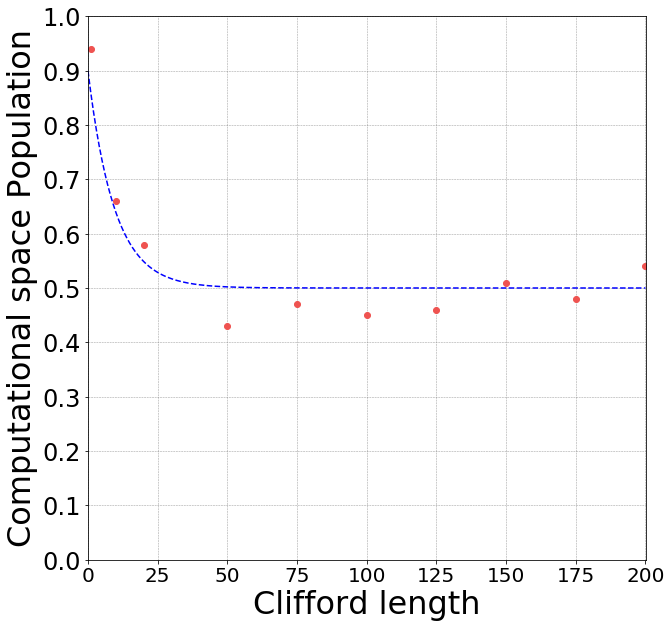

In [142]:
plt.figure(figsize=(8, 6))

fig,ax = plt.subplots(figsize=(10, 10))


## set grid
ax.grid(which = "major", axis = "y", color = "gray", alpha = 0.8, linestyle = "--", linewidth = 0.5)
ax.grid(which = "major", axis = "x", color = "gray", alpha = 0.8, linestyle = "--", linewidth = 0.5)

## set axis
plt.ylabel("Computational space Population", fontsize= 32)
ax.set_yticks(np.linspace(0, 1, 11))
ax.set_yticklabels(["0.0", "0.1", "0.2", "0.3", "0.4", "0.5", "0.6", "0.7", "0.8", "0.9", "1.0"], 
                   fontsize= 24)
plt.ylim(0,1)


plt.xlabel("Clifford length", fontsize= 32)
ax.set_xticks(np.linspace(0, 200, 9))

ax.set_xticklabels(["0", "25", "50", "75", "100", "125", "150", "175", "200"],
                   fontsize= 20)
plt.xlim(-0.1,200.1)


m = np.linspace(0, 200, num=201) # gate sequence length (number)

y =  0.5 + 0.4 * (0.9 ** m) + (np.random.normal(size = 201))*0.001

def test(m, b ,c):   # a = A; b = B; c = lambda_1
    return 0.5 + b * (c ** m )

param, param_cov = curve_fit(test, m, y, bounds=(0, [1., 1.]))

ans = 0.5 + param[0] * (param[1]**m)
plt.plot(m, ans, '--', color ='blue', label ="optimized data")

print(param[0])
print(param[1])


## data
plt.plot(length_vector, leakprob_list, 'o', color='#EF5350')



In [ ]:
from qiskit import IBMQ
IBMQ.get_provider(hub='ibm-q-keio', group='keio-internal', project='keio-students')
device = 

In [ ]:
# # Create the RB fitter
# backend = qiskit.Aer.get_backend('qasm_simulator')
# basis_gates = ['u1','u2','u3','cx'] 
# shots = 1000
# qobj_list = []

# if is_leakage:
#     rb_fit_list = []
#     for meas_x in range(2**nQ):
#         rb_fit = rb.RBFitter(None, xdata, rb_opts['rb_pattern'])
#         rb_fit_list.append(rb_fit)
# else:
#     rb_fit = rb.RBFitter(None, xdata, rb_opts['rb_pattern'])


# for rb_seed,rb_circ_seed in enumerate(rb_circs):

#     print('################### Compiling seed %d ###################'%rb_seed)
    
#     if is_leakage:
        
#         for meas_x in range(2**nQ):
#             print("meas_x: %d"%meas_x)
            
            
#             _rb_circ_seed_xmeas = []
#             _len_v = len(length_vector)
#             for i in range(_len_v):
#                 _rb_circ_seed_xmeas.append(rb_circ_seed[i][meas_x])
            
#             new_rb_circ_seed = qiskit.compiler.transpile(_rb_circ_seed_xmeas, basis_gates=basis_gates)
#             qobj = qiskit.compiler.assemble(new_rb_circ_seed, shots=shots)
#             print('Simulating seed %d'%rb_seed)

#             ## run on simulator 
#             job = backend.run(qobj, noise_model=noise_leakage, backend_options={'max_parallel_experiments': 0})
#             qobj_list.append(qobj)
            
#             result = job.result()
            
            
# #             # Add data to the fitter
# #             rb_fit_list[meas_x].add_data(job.result())
            

#             print('After seed %d, alpha: %f, EPC: %f'%(rb_seed, rb_fit_list[meas_x].fit[0]['params'][1], rb_fit_list[meas_x].fit[0]['epc']))
            

#     else: 
#         print(rb_circ_seed)
#         new_rb_circ_seed = qiskit.compiler.transpile(rb_circ_seed, basis_gates=basis_gates)
#         qobj = qiskit.compiler.assemble(new_rb_circ_seed, shots=shots)
#         print('Simulating seed %d'%rb_seed)

#         ## run on simulator 
#         job = backend.run(qobj, noise_model=noise_model, backend_options={'max_parallel_experiments': 0})
#         qobj_list.append(qobj)

#         # Add data to the fitter
#         _results = job.result()
#         rb_fit.add_data(_results)
            
#         print('After seed %d, alpha: %f, EPC: %f'%(rb_seed, rb_fit.fit[0]['params'][1], rb_fit.fit[0]['epc']))
        

## output: 00

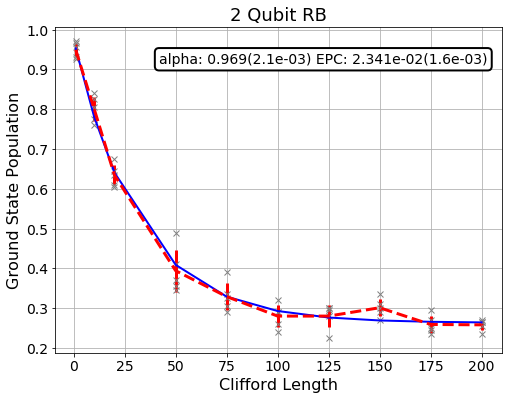

In [21]:
plt.figure(figsize=(8, 6))
ax = plt.subplot(1, 1, 1)

# Plot the essence by calling plot_rb_data
rb_fit_list[0].plot_rb_data(0, ax=ax, add_label=True, show_plt=False)
    
# Add title and label
ax.set_title('%d Qubit RB'%(nQ), fontsize=18)

plt.show()

## output: 01

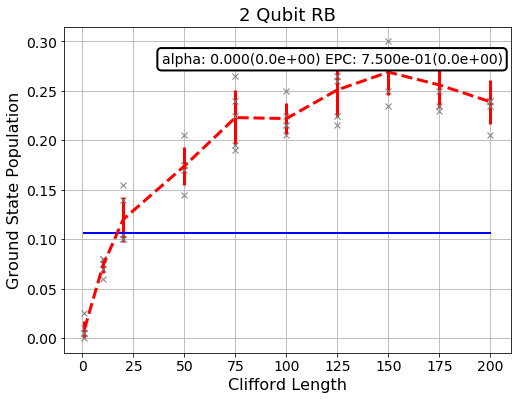

In [22]:
plt.figure(figsize=(8, 6))
ax = plt.subplot(1, 1, 1)

# Plot the essence by calling plot_rb_data
rb_fit_list[1].plot_rb_data(0, ax=ax, add_label=True, show_plt=False)
    
# Add title and label
ax.set_title('%d Qubit RB'%(nQ), fontsize=18)

plt.show()

## output: 10

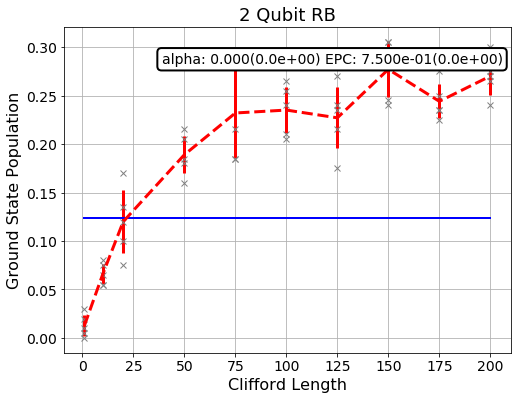

In [23]:
# plt.figure(figsize=(8, 6))
# ax = plt.subplot(1, 1, 1)

# # Plot the essence by calling plot_rb_data
# rb_fit_list[2].plot_rb_data(0, ax=ax, add_label=True, show_plt=False)
    
# # Add title and label
# ax.set_title('%d Qubit RB'%(nQ), fontsize=18)

# plt.show()

## output: 11

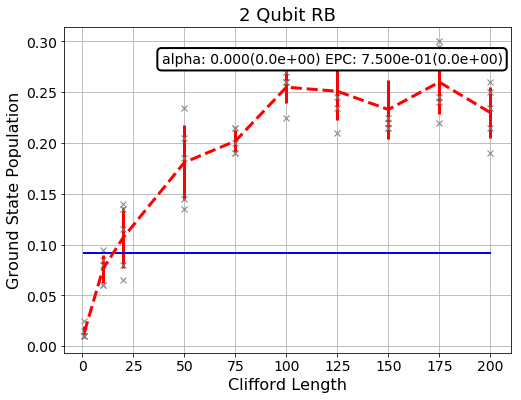

In [24]:
plt.figure(figsize=(8, 6))
ax = plt.subplot(1, 1, 1)

# Plot the essence by calling plot_rb_data
rb_fit_list[3].plot_rb_data(0, ax=ax, add_label=True, show_plt=False)
    
# Add title and label
ax.set_title('%d Qubit RB'%(nQ), fontsize=18)

plt.show()